In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import io

from IPython.display import display
from PIL import Image
from IPython.display import HTML
from scipy.ndimage import gaussian_filter1d 

In [2]:
# # 加载图像或视频
# image_path = 'Red.jpg'
# image_path = 'Green.jpg'
# image_path = 'Blue.jpg'
image_path = 'BadInput.jpeg'

sigma = 2
tolorate = 0.10

In [3]:
def read_image_or_video(input_path):
    # 获取文件扩展名
    file_ext = os.path.splitext(input_path)[1].lower()
    #print(f"file_ext: {file_ext}")
    # 如果文件是图像格式，直接读取图像
    if file_ext in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']:
        image = cv2.imread(input_path)
        if image is None:
            print(f"无法读取图像文件: {input_path}")
        print(f"file_ext: {file_ext}图片")
        return image

    # 如果文件是视频格式，读取第一帧
    elif file_ext in ['.mp4', '.avi', '.mov', '.mkv', '.flv', '.wmv']:
        cap = cv2.VideoCapture(input_path)
        print(f"file_ext: {file_ext}视频")
        if not cap.isOpened():
            print(f"无法打开视频文件: {input_path}")
            return None

        ret, frame = cap.read()  # 读取视频的第一帧
        cap.release()  # 释放视频资源

        if ret:
            return frame
        else:
            print("无法读取视频的第一帧")
            return None

    else:
        print("不支持的文件格式")
        return None

image = read_image_or_video(image_path)



file_ext: .jpeg图片


RED 500Hz 
Green 2000Hz
Blue 8000Hz

In [4]:
# 将图像从BGR转换为RGB以便于matplotlib显示
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 分别提取 R, G, B 三个通道
r_channel = image_rgb[:, :, 0]  # 红色通道
g_channel = image_rgb[:, :, 1]  # 绿色通道
b_channel = image_rgb[:, :, 2]  # 蓝色通道

# 计算每个通道的像素总和
r_sum = np.sum(r_channel)
g_sum = np.sum(g_channel)
b_sum = np.sum(b_channel)

# 输出哪个颜色占比最多
if r_sum > g_sum and r_sum > b_sum:
    Base_Freq = 500 #in Hz
    print("红色占比最多")
elif g_sum > r_sum and g_sum > b_sum:
    Base_Freq = 2000 #in Hz
    print("绿色占比最多")
else:
    Base_Freq = 8000 #in Hz
    print("蓝色占比最多")


蓝色占比最多


In [5]:
gray_image = cv2.normalize(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), None, 0, 255, cv2.NORM_MINMAX)

# 显示灰度图像
# plt.imshow(gray_image, cmap='gray')
# plt.title('Grayscale Image')
# plt.show()


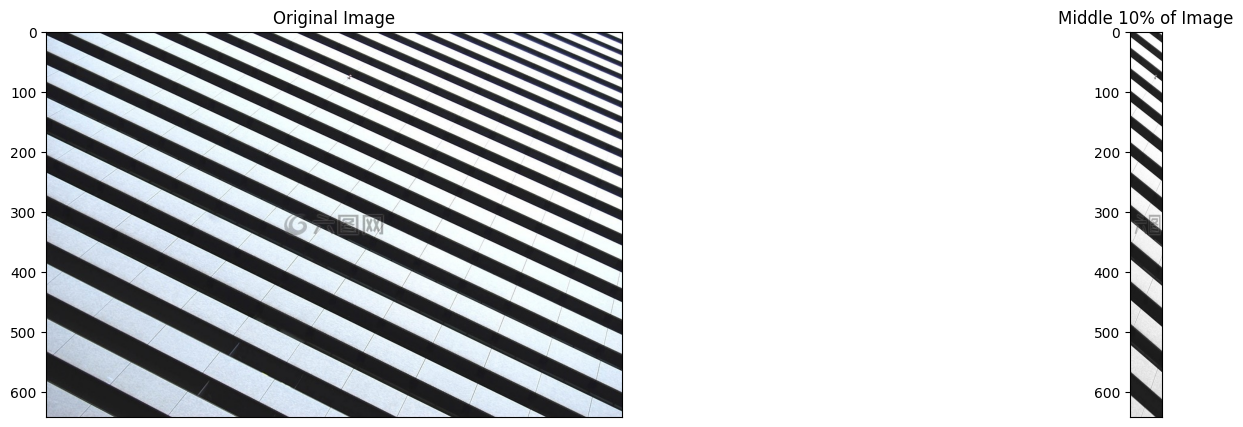

In [6]:
# 获取图像的高度和宽度
height, width = gray_image.shape

# 计算宽度的 10%
width_10_percent = int(width * 0.1)

# 计算中间部分的起始和结束列
start_col = (width - width_10_percent) // 2
end_col = start_col + width_10_percent

# 提取中间 10% 列的图像
middle_10_percent = gray_image[:, start_col:end_col]

# 计算中间 10% 列的平均值
mean_projection_middle = np.mean(middle_10_percent, axis=1)

# 打印结果
#print("中间 10% 列的 mean_projection:", mean_projection_middle)

# # 显示图像
# 原始
fig, axs = plt.subplots(1, 2, figsize=(20,5))
axs[0].imshow(image_rgb) 
axs[0].set_xticks([]) 
axs[0].set_title('Original Image')

# 中间 10% 区域
axs[1].imshow(middle_10_percent, cmap='gray', aspect=16/9) 
axs[1].set_title('Middle 10% of Image')
axs[1].set_xticks([]) 

plt.subplots_adjust(wspace=0.1) 
plt.show()

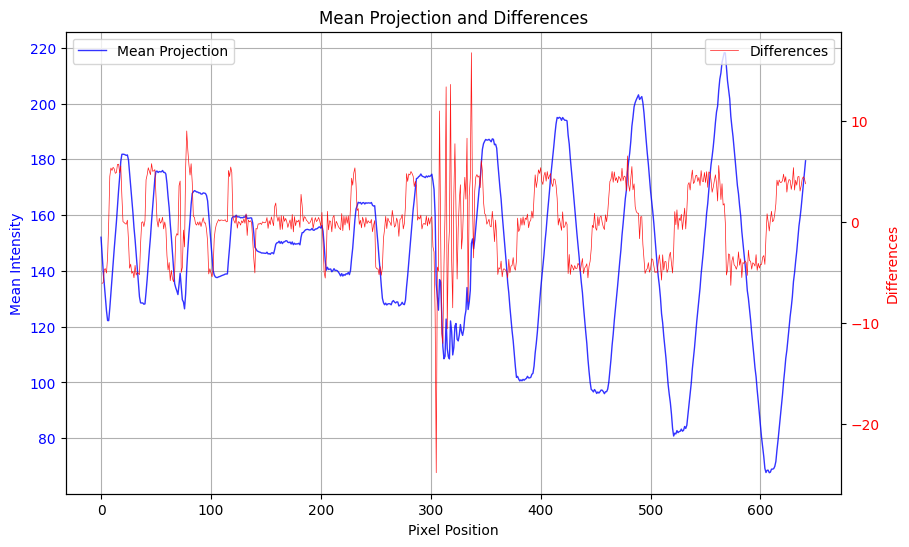

In [7]:
mean_projection = np.mean(middle_10_percent, axis=1)
differences = np.diff(mean_projection)
# 创建新的图形
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制 mean_projection
ax1.plot(mean_projection, label='Mean Projection', color='blue', alpha=0.8, lw=1)
ax1.set_xlabel('Pixel Position')
ax1.set_ylabel('Mean Intensity', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Mean Projection and Differences')

# 创建第二个 y 轴
ax2 = ax1.twinx()  
ax2.plot(range(1, len(mean_projection)), differences, label='Differences', color='red', alpha=0.9, lw=0.5)
ax2.set_ylabel('Differences', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 添加图例（可选）
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 添加网格
ax1.grid()

# 显示图形
plt.show()

In [8]:
smoothed_projection_gaussian = gaussian_filter1d(mean_projection, sigma)

threshold_value = (np.min(smoothed_projection_gaussian)+np.max(smoothed_projection_gaussian))/2
print(f"阈值: {threshold_value}")

阈值: 141.53056630423575


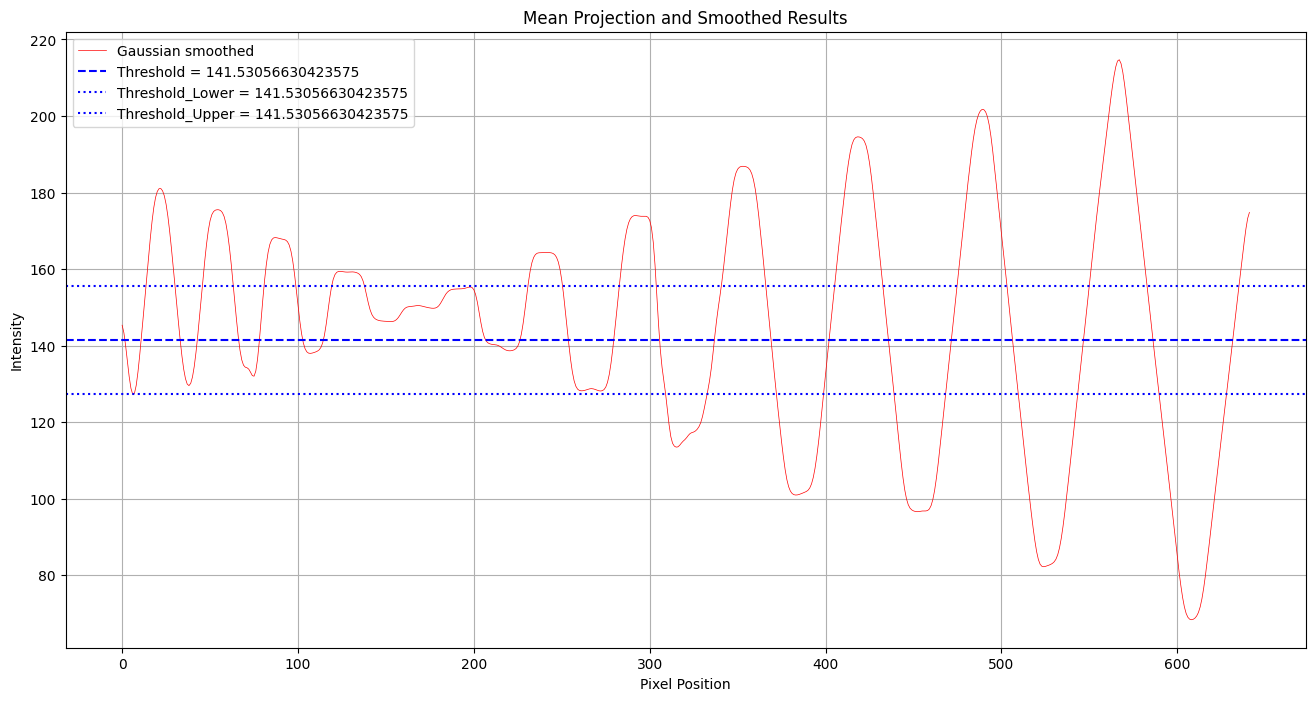

In [9]:
# 绘制 Gaussian 滤波平滑结果
plt.figure(figsize=(16, 8))
plt.plot(smoothed_projection_gaussian, label='Gaussian smoothed', color='red', lw=0.5)
plt.axhline(y=threshold_value, color='blue', linestyle='--', label=f'Threshold = {threshold_value}')
plt.axhline(y=threshold_value*(1-tolorate), color='blue', linestyle=':', label=f'Threshold_Lower = {threshold_value}')
plt.axhline(y=threshold_value*(1+tolorate), color='blue', linestyle=':', label=f'Threshold_Upper = {threshold_value}')
# 添加标题和标签
plt.title('Mean Projection and Smoothed Results')
plt.xlabel('Pixel Position')
plt.ylabel('Intensity')
plt.legend(loc='upper left') 
plt.grid()
# 显示图形
plt.show()

In [10]:
np.savetxt("output.txt",smoothed_projection_gaussian,delimiter=',')

[6, 8, 296, 31, 32, 33, 33, 36, 35, 40, 40, 46, 6]
[8, 296, 31, 32, 33, 33, 36, 35, 40, 40]


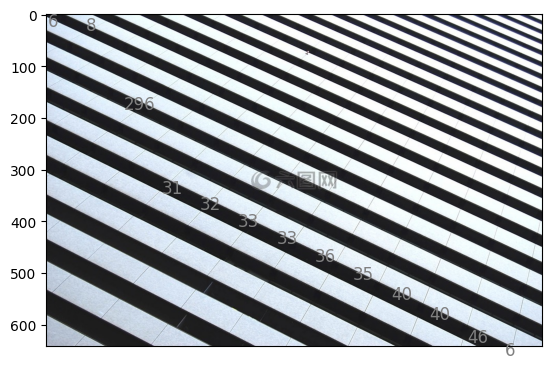

In [11]:
stripe_widths = []
current_width = 0
invert = bool(not(smoothed_projection_gaussian[0] > threshold_value)) #false if条带，true if 背景
#print(invert)
for lightvalue in smoothed_projection_gaussian:
    
    #根据之前的数据放宽判断标准，条带的后续尽量归入条带，背景的后续尽量归入背景

    adjusted_threshold = threshold_value * ((1+tolorate) if invert else (1-tolorate))
    if (lightvalue > adjusted_threshold) ^ (invert):  # 当前是条带
        current_width += 1
    else:  # 当前是背景
        if current_width > 0:
            stripe_widths.append(current_width)
            current_width = 1
            invert = not invert

#最后一个条带        
if current_width > 0:
    stripe_widths.append(current_width)

# 掐头去尾            
trimmed_stripe_widths = stripe_widths[1:-1] 
# 如果元素个数为奇数，去除最后一个元素
if len(trimmed_stripe_widths) % 2 == 1:
    trimmed_stripe_widths = trimmed_stripe_widths[:-1]  # 去除最后一个元素
    
print(stripe_widths)
print(trimmed_stripe_widths)

# 提取奇偶数索引的元素
odd_elements = trimmed_stripe_widths[::2]
even_elements = trimmed_stripe_widths[1::2]

# 计算元素的平均值
average_odd = np.mean(odd_elements)
average_even = np.mean(even_elements)

# 检查每个奇偶数索引的元素与平均值的差值是否小于等于4
is_odd_valid = all(abs(x - average_odd) <= 4 for x in odd_elements)
is_even_valid = all(abs(x - average_even) <= 4 for x in even_elements)

plt.imshow(image_rgb)
plt.gca().axes.get_xaxis().set_visible(False)
abs_y_pos = 0
for index, y_pos in enumerate(stripe_widths):
    abs_y_pos += y_pos
    plt.text(x=2+image_rgb.shape[1]/len(stripe_widths)*index, y=abs_y_pos-y_pos/2+20, s=stripe_widths[index], fontsize=12, color='gray')
plt.show()

In [12]:
#RollingShutterTime = (image height / height of bands measured * number of bands measured)*(1000/BaseFreq) in ms
RollingShutterTime = (len(mean_projection))/sum(trimmed_stripe_widths)*(len(trimmed_stripe_widths) / 2) * (1000/Base_Freq)

In [13]:
if is_odd_valid and is_even_valid:
    display(HTML(f'<span style="color: blue;font-size: 40px;">Base Freq: {Base_Freq} Hz<br>RollingShutterTime: {RollingShutterTime} ms</span>'))
else:
    display(HTML(f'<span style="color: red;font-size: 40px;">Bad Input!   Base Freq: {Base_Freq }Hz<br>RollingShutterTime: {RollingShutterTime} ms</span>'))
